## Cat vs Dog
![](https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg)

## Importing Required libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Extracting Files

In [ ]:
import zipfile
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip",'r') as z:
    z.extractall(".")
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip",'r') as z:
    z.extractall(".")

In [ ]:
filenames = os.listdir('/kaggle/working/train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(str(1))
    else:
        categories.append(str(0))

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

## Exploratory Data Analysis

In [ ]:
df['category'] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [ ]:
df.head() , df.tail()

In [ ]:
sns.countplot(df['category'], palette='cool')

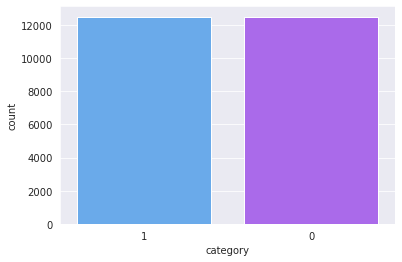

## Visualizing Data
##### Run this cell again and again, it will randomly show image from our dataset.

In [ ]:
sample = filenames[473]
image = load_img("/kaggle/working/train/"+sample)
plt.imshow(image)

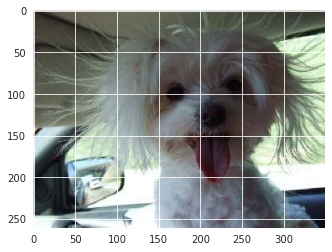

## Splitting of Dataset

In [ ]:
train_data, valid_data = train_test_split(df, test_size=0.2, random_state = 42)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

## Generating Training Data

In [ ]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=15
)

## Generating Validation Data

In [ ]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=15
)

## *Deep CNN Model*

In [ ]:
model = keras.models.Sequential([
                         keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='valid',activation= 'relu', input_shape=(128,128,3)),
                         keras.layers.MaxPooling2D(pool_size=(2,2)),
                         keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
                         keras.layers.MaxPooling2D(pool_size=(2,2)),
                         keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
                         keras.layers.MaxPooling2D(pool_size=(2,2)),
                         keras.layers.Flatten(),
                         keras.layers.Dense(units=128, activation='relu'),
                         keras.layers.Dropout(0.25),
                         keras.layers.Dense(units=256, activation='relu'),
                         keras.layers.Dropout(0.5),
                         keras.layers.Dense(units=256, activation='relu'),
                         keras.layers.Dropout(0.25),                        
                         keras.layers.Dense(units=128, activation='relu'),
                         keras.layers.Dropout(0.10),                         
                         keras.layers.Dense(units=2, activation='softmax')
])
model.summary()

##### This will show how our model architecture looks like in the form of an image.

In [ ]:
keras.utils.plot_model(model, 'model.png')

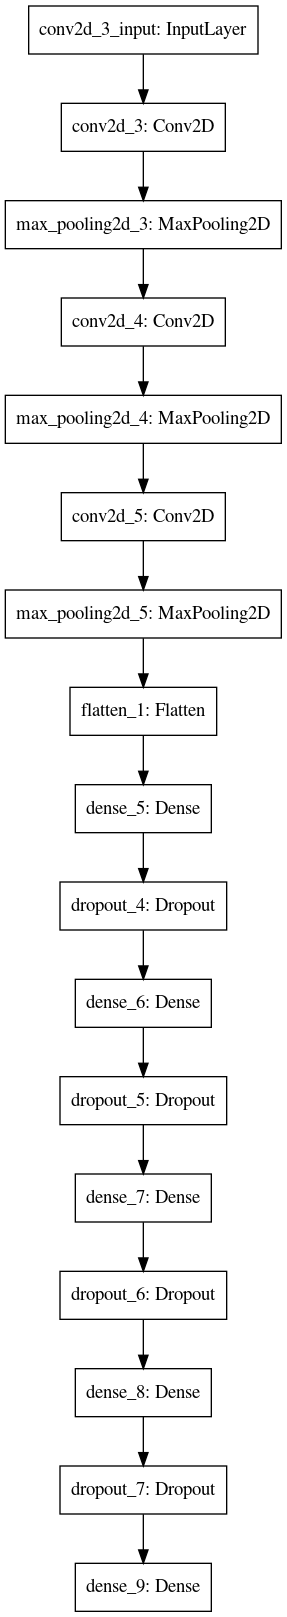

In [ ]:
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

## Callbacks

In [ ]:
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

## Model Training

In [ ]:
total_train = train_data.shape[0]
total_validate = valid_data.shape[0]
batch_size=15
epochs=30

In [ ]:
history = model.fit(train_generator, epochs=epochs, verbose=1, validation_data=valid_generator,
                   validation_steps=total_validate//batch_size,
                   steps_per_epoch=total_train//batch_size,
                   callbacks=callbacks) 

## Saving Model

In [ ]:
model.save('cat-vs-dog-model.h5')

## Model Plotting

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

![](https://www.kaggleusercontent.com/kf/83339988/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..OoD3pShREofW9RIKSxkxqQ.ib5uZ1oEnBQ84_IFiN2dhTnWsu3dg3sgq9B8nC038eKD80EctLNsJT6FmBzAENC-4y1xpEO_sttfF9X3In7U13KhpWOg0Tew-RV5VG8X_IEpPfGHeBl759zgTL91WraUpnbEFEiyUDOd-re1ayrfoYiSsi6-OFHdC6osNCMFUiXriZsfkjYMod2uYpldQAzhtCNIIjVgVkdUP5db3KBozW-LAxsOSRmbfrZtdqnOIe-ypjXLVyKrBwugIMUVcya3CT-dym0ztY1vu60Pl3ENMAI1TdaORnx690PvFE7VgLCfAsf8BhUljSdmTnifBMVb8LIsG0i__35Rgt3aHaHaZ5xgrOPKI4RUFpXyY39ET3qE3q_U0S2xvH46CId0TD_CWZuVx17-KyhYwHUBKcFzOTrB7zunf7jTHbUWDi0rMlRCq7LWSq_OweR-4OP_fRrGc9Rf64dXhjStmtGCbdjXAO2Bj_Q5BcUFCzzS3xS5sqzYs0NsenrlFFJeZ1IG7lD2NJX2KiuJBsXZGpU74HgtPUk1NGYREWZSKtSkkoPjwoIO78MJq0WJ5eepgeHX1koTgob0wdFuFvbP0X0OOrDGb70x0WKjhVPg-_f2be_XwfKUW4jG4S472ZzkFsSVhh0OMkVEr3xBi03zP8FiYKhS8AAO4slPb0oOaA6NiBSG6iMrnmdBAw1VxxsvIFvHnFceqw6AAAIlphNbAdILuPKLmw.mvOImk3jGmNo3HEtkjau6A/__results___files/__results___32_0.png)

## Model Testing

In [ ]:
nb_samples = valid_data.shape[0]
predict = model.predict(valid_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
valid_data['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
valid_data['category'] = valid_data['category'].replace(label_map)
valid_data['category'] = valid_data['category'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
# make a prediction for a new image.

sample = filenames[60]
image = load_img("/kaggle/working/train/"+sample, target_size=(128,128))

img = img_to_array(image)
img = img.reshape(1, 128, 128, 3)
img = img.astype('float32')

result = model.predict(img)
result = np.argmax(result, axis=-1)

if result == 0:
    print("It's a Cat.")
else:
    print("It's a Dog.")
    
plt.imshow(image)

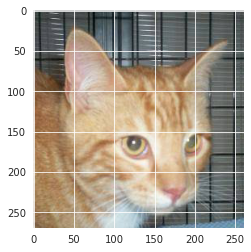